In [11]:
import os
import cv2
from PIL import Image
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.datasets as dsets
import torchvision

In [3]:
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
training_path = "/content/drive/MyDrive/data/Training"
testing_path = "/content/drive/MyDrive/data/Testing"

In [6]:
for label, subdir in enumerate([d for d in os.listdir(training_path) if not d.startswith(".")]):
  print(label, subdir)

0 meningioma_tumor
1 no_tumor
2 pituitary_tumor
3 glioma_tumor


In [7]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
train_data = dsets.ImageFolder(training_path, train_transform)
test_data = dsets.ImageFolder(testing_path, test_transform)

In [10]:
train_data.samples[0][0]

'/content/drive/MyDrive/data/Training/glioma_tumor/gg (1).jpg'

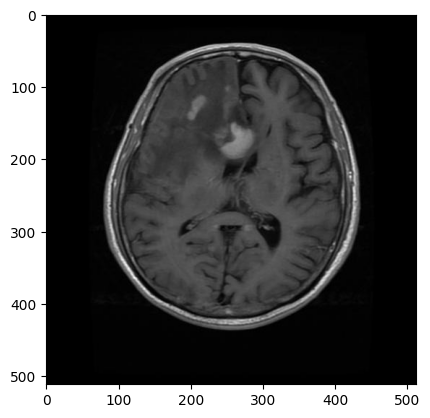

In [12]:
img = cv2.imread("/content/drive/MyDrive/data/Training/glioma_tumor/gg (3).jpg")
plt.imshow(img)
plt.show()

In [13]:
test_data.samples[0][0]

'/content/drive/MyDrive/data/Testing/glioma_tumor/image(1).jpg'

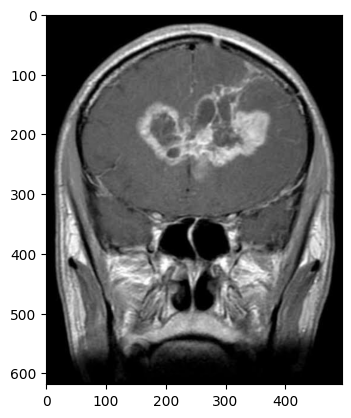

In [14]:
img = cv2.imread("/content/drive/MyDrive/data/Testing/glioma_tumor/image(1).jpg")
plt.imshow(img)
plt.show()

In [15]:
num_classes = 4

model = models.inception_v3(pretrained=True)
model.aux_logits = False

for parameter in model.parameters():
    parameter.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 10),
    nn.Linear(10, num_classes)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 112MB/s] 


In [16]:
def train_model(model, train_loader, val_loader ,criterion, optimizer, start_epoch, num_epochs, resume_training=False, patience=3):
  if resume_training:
    start_epoch, _ = load_checkpoint()

  best_val_loss = np.inf
  epochs_no_improve = 0

  for epoch in range(start_epoch, num_epochs):
    model.train()
    total_batch = len(train_loader)

    for i, (inputs, labels) in enumerate(train_loader):
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (i+1) % 5 == 0:
        print(f'Epoch[{epoch+1}/{num_epochs}] Iter[{i+1} / {total_batch}] Loss:{loss.item():.4f}')


    model.eval()
    val_loss = 0.0
    with torch.no_grad():
      for inputs, labels in val_loader:
        outputs =  model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      epochs_no_improve = 0

      save_checkpoint({
          'epoch': epoch + 1,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': loss.item(),
      })

    else:
      epochs_no_improve += 1

    if epochs_no_improve >= patience:
      print("Early Stopping")
      break

In [17]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [18]:
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)

In [19]:
def load_checkpoint(filename='checkpoint.pth.tar'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return epoch, loss

In [ ]:
param_grid = {
    'lr': [0.1, 0.01, 0.001],
    'batch_size': [16, 32, 64],
    'num_epochs': [10, 20]
}

grid = ParameterGrid(param_grid)
best_accuracy = 0
best_params = None

resume_training = True

for params in grid:
    lr = params['lr']
    batch_size = params['batch_size']
    num_epochs = params['num_epochs']

    print(f'Tuning for lr: {lr}, batch size: {batch_size}, epochs: {num_epochs}')

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

    train_model(model, train_loader, test_loader, criterion, optimizer, start_epoch=15, num_epochs=num_epochs, resume_training=resume_training)
    accuracy = evaluate_model(model, test_loader)

    print(f'Accuracy with lr: {lr}, batch size: {batch_size}, epochs: {num_epochs} -> {accuracy:.2f}%')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print(f'Best Hyperparameters: {best_params}')
print(f'Best Accuracy: {best_accuracy:.2f}%')

Tuning for lr: 0.1, batch size: 16, epochs: 10
Accuracy with lr: 0.1, batch size: 16, epochs: 10 -> 47.97%
Tuning for lr: 0.1, batch size: 16, epochs: 20
Epoch[13/20] Iter[4.0055555555555555] Loss:5.2132
Epoch[13/20] Iter[9.005555555555556] Loss:6.3100
Epoch[13/20] Iter[14.005555555555556] Loss:12.2448
Epoch[13/20] Iter[19.005555555555556] Loss:23.4236
Epoch[13/20] Iter[24.005555555555556] Loss:9.3612
Epoch[13/20] Iter[29.005555555555556] Loss:8.6799
Epoch[13/20] Iter[34.00555555555555] Loss:11.1279
Epoch[13/20] Iter[39.00555555555555] Loss:24.4526
Epoch[13/20] Iter[44.00555555555555] Loss:25.6494
Epoch[13/20] Iter[49.00555555555555] Loss:19.4535
Epoch[13/20] Iter[54.00555555555555] Loss:10.9875
Epoch[13/20] Iter[59.00555555555555] Loss:9.6514
Epoch[13/20] Iter[64.00555555555556] Loss:7.4927
Epoch[13/20] Iter[69.00555555555556] Loss:15.0477
Epoch[13/20] Iter[74.00555555555556] Loss:18.2842
Epoch[13/20] Iter[79.00555555555556] Loss:22.6683
Epoch[13/20] Iter[84.00555555555556] Loss:11.81

In [19]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:

    images = images
    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 49.238579 %
